In [9]:
using Distributions
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Random

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [79]:
n = 25
μ = 25
τ = 0.01

Random.seed!(123)

data = rand(Normal(μ, sqrt(inv(τ))), n);

In [18]:
@model [ default_factorisation = MeanField() ] function iid_gaussians(n)
    
    m ~ GaussianMeanPrecision(0.0, 0.001)
    w ~ Gamma(0.01, 100.0)
    
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ GaussianMeanPrecision(m, w) where { q = MeanField() }
    end
    
    return m, w, y
end

iid_gaussians (generic function with 1 method)

In [19]:
function inference(data, n_its)
    n = length(data)
    
    model, (m, w, y) = iid_gaussians(n)
    
    mbuffer = Vector{Marginal}()
    wbuffer = Vector{Marginal}()
    fbuffer = Vector{Float64}()
    
    fes = PendingScheduler()
    
    msub = subscribe!(getmarginal(m), (v) -> push!(mbuffer, v))
    wsub = subscribe!(getmarginal(w), (v) -> push!(wbuffer, v))
    fsub = subscribe!(score(BetheFreeEnergy(), model, fes), (v) -> push!(fbuffer, v))
    
    setmarginal!(m, GaussianMeanPrecision(0.0, 0.01))
    setmarginal!(w, Gamma(0.001, 1000.0))
    
    for i in 1:n_its
        update!(y, data)
        release!(fes)
    end
    
    unsubscribe!(msub)
    unsubscribe!(wsub)
    unsubscribe!(fsub)
    
    return mbuffer[1:end], wbuffer[1:end], fbuffer[1:end]
end

inference (generic function with 1 method)

In [80]:
ms, ws, fe = inference(data, 10);

In [81]:
using Plots

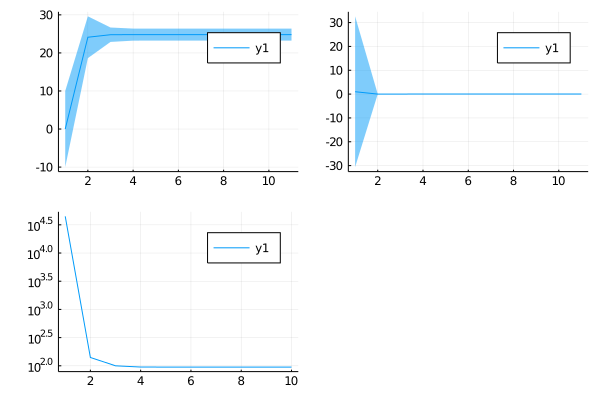

In [85]:
p1 = plot(mean.(ms), ribbon = std.(ms))
p2 = plot(mean.(ws), ribbon = std.(ws))
p3 = plot(fe, yscale = :log10)

plot(p1, p2, p3)

In [86]:
@benchmark inference($data, 10)

BenchmarkTools.Trial: 
  memory estimate:  1.32 MiB
  allocs estimate:  23828
  --------------
  minimum time:     1.057 ms (0.00% GC)
  median time:      1.298 ms (0.00% GC)
  mean time:        1.572 ms (14.06% GC)
  maximum time:     10.230 ms (76.69% GC)
  --------------
  samples:          3182
  evals/sample:     1